In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import re

try:
    pass
except ImportError:
    pass

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from src.model import BaseLineModel

DATA_PATH = "./data/evaluation/"

In [202]:
%pip install word2vec

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build word2vec
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Building wheel for word2vec (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [157 lines of output]
      C:\Users\Ready2Go\AppData\Local\Temp\pip-build-env-it9_nf29\overlay\Lib\site-packages\setuptools\dist.py:759: SetuptoolsDeprecationWarning: License classifiers are deprecated.
      !!
      
              ********************************************************************************
              Please consider removing the following classifiers in favor of a SPDX license expression:
      
              License :: OSI Approved :: Apache Software License
      
              See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
              ********************************************************************************
      
      !!
        self._finalize_license_expression()
      running bdist_wheel
      C:\Users\Ready2Go\AppData\Local\Temp\pip-build-env-it9_nf29\overlay

In [ ]:
df_test = pd.read_csv(f'{DATA_PATH}test.csv')
X_test = df_test.drop(columns=['strength'])
y_test = df_test['strength']


def prettify_filename(file_name):
    file_name = re.sub(r'[-_]+', ' ', file_name)
    pretty = ' '.join(word.capitalize() for word in file_name.strip().split())
    
    return pretty

files = [f for f in os.listdir(DATA_PATH) if os.path.isfile(os.path.join(DATA_PATH, f)) if not f.__contains__("test")]

data_sets = dict()

for file in files:
    file_name, file_ending = file.rsplit(".", 1)
    print(f"Reading '{file_name}'")
    file_path = DATA_PATH + file

    match file_ending:
        case "csv":
            df_train = pd.read_csv(file_path)
        case "parquet":
            df_train = pd.read_parquet(file_path)
        case _:
            raise NameError("File does not have a valid format")

    if set(df_train.columns) != set(df_test.columns):
        diffset = set(df_test.columns).difference(set(df_train.columns))
        raise AttributeError(f"faulty column{'s' if len(diffset) > 1 else ''}: {diffset}")
    

    X_train = df_train.drop(columns=['strength'])
    y_train = df_train['strength']
    del df_train
    data_sets[file_name] = {"X_train": X_train, "y_train": y_train, "name": prettify_filename(file_name)}


Reading 'train copy'
Reading 'train'


In [201]:
def train_model(X_train, y_train):
    model = BaseLineModel(
        n_estimators=100, 
        random_state=76344
    )
    model.fit(X_train, y_train)
    return model

max_name_len = max([len(data['name']) for data in data_sets.values()])
pbar = tqdm(data_sets.items())

models = dict()

for _, data in pbar:
    pbar.set_description("Processing %s" % data['name'].ljust(max_name_len))
    model = train_model(data['X_train'], data['y_train'])
    y_pred = model.predict(X_test)
    models[data['name']] = {'name': data['name'], 'model': model, 'y_pred': y_pred, "error": y_test - y_pred}


Processing Train     : 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]


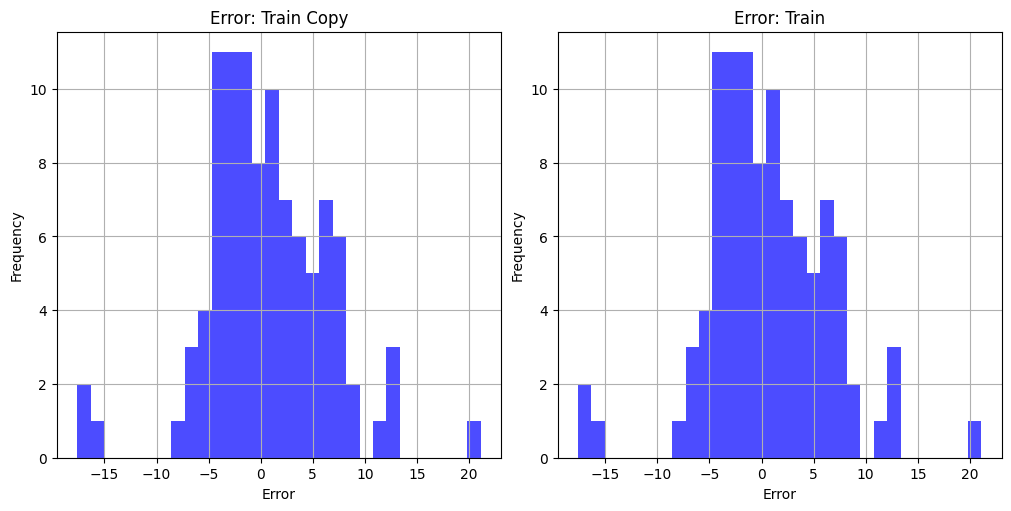

In [ ]:
import matplotlib.pyplot as plt

# Number of models
model_names = list(models.keys())
num_models = len(model_names)

# Create subplots: one row, multiple columns
fig, axes = plt.subplots(1, num_models, figsize=(5 * num_models, 5), constrained_layout=True)

if num_models == 1:
    axes = [axes]  # ensure axes is always iterable

for i, name in enumerate(model_names):
    ax = axes[i]
    errors = models[name]['error']
    ax.hist(errors, bins=30, alpha=0.7, color='blue')
    ax.set_title(f"Error: {name}")
    ax.set_xlabel("Error")
    ax.set_ylabel("Frequency")
    ax.grid(True)

plt.show()

In [ ]:
import random

# Range: 1 to 100, choose 10 unique random numbers
numbers = random.sample(range(1, 101), 20)
numbers = list(zip(numbers[::2], numbers[1::2]))


[(4, 60),
 (37, 77),
 (45, 31),
 (17, 27),
 (62, 24),
 (91, 38),
 (19, 89),
 (75, 21),
 (90, 36),
 (14, 7)]